<a href="https://colab.research.google.com/github/umair-hassan2/Assignment-Contact-App/blob/master/Resnet18_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.utils.data import DataLoader
from google.colab import drive
import matplotlib.pyplot as plt
import time
from tempfile import TemporaryDirectory
from PIL import Image
import requests
from io import BytesIO
import base64

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu'
print(f"Using {device} device")

Using cuda device


In [5]:
_mean = torch.Tensor([0.485, 0.456, 0.406])
_std  = torch.Tensor([0.229, 0.224, 0.225])

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=_mean, std=_std)
    ]
    ),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=_mean, std=_std)
    ]
    )
}

In [7]:
DRIVE_BASE_PATH = '/content/drive/MyDrive'
DATASET_BASE_PATH = 'colab-data/resnet18'
MODEL_PHASES = ['train', 'val']
BATCH_SIZE= 4
TOTAL_EPOCHS = 25

In [8]:
image_datasets = {x: datasets.ImageFolder(os.path.join(DRIVE_BASE_PATH, DATASET_BASE_PATH, x), data_transforms[x]) for x in MODEL_PHASES}
data_loaders = {x: DataLoader(image_datasets[x], BATCH_SIZE, shuffle=True, num_workers=4) for x in MODEL_PHASES}

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [9]:
classes = image_datasets['train'].classes
dataset_sizes = {x: len(image_datasets[x]) for x in MODEL_PHASES}

In [10]:
def unnormalize_image(image_tensor, mean, std):
  return image_tensor * std + mean

In [11]:
def show_image(image_tensor, title=None, ax=None): # Add ax parameter
  # Un-Normalize the image
  img = image_tensor.permute(1, 2, 0)
  img = unnormalize_image(img, _mean, _std).clamp(0, 1)

  if ax is None:
    plt.imshow(img.numpy())
    if title is not None:
      plt.title(title)
    plt.pause(0.001)
  else:
    ax.imshow(img.numpy())
    if title is not None:
      ax.set_title(title)
    ax.axis('off') # Turn off axis labels for better visualization

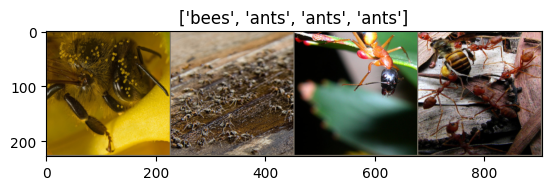

In [12]:
inputs, labels = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)
show_image(out, title=[classes[x] for x in labels])

In [21]:
def train_model(model, optim, loss_function, scheduler, num_epochs= TOTAL_EPOCHS):
  since = time.time()

  # save model checkpoints
  with TemporaryDirectory() as tempdir:
    best_model_path = os.path.join(tempdir, 'best_model.pt')
    best_acc = 0.0

    for epoch in range(num_epochs):
      print(f"Epoch {epoch + 1}/{num_epochs}")
      print('-' * 10)

      for phase in MODEL_PHASES:
        if phase == 'train':
          model.train()
        else:
          model.eval()

        running_loss = 0.0
        running_corrects = 0.0
        running_top_5_corrects = 0.0

        for inputs, labels in data_loaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          optim.zero_grad()

          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = loss_function(outputs, labels)

            if phase == 'train':
              loss.backward()
              optim.step()

            n_corrects = torch.sum(preds == labels.data)
            n_loss = loss * outputs.size(0)

            running_loss += n_loss
            running_corrects += n_corrects

        if phase == 'train':
          scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f"phase: {phase} Loss: {epoch_loss:.4f} Top-1 Acc: {epoch_acc:.4f}")

        if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(model.state_dict(), best_model_path)
      print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.4f}s")
    print(f"Best Acc: {best_acc:.4f}")

    model.load_state_dict(torch.load(best_model_path, weights_only=True))

    return model

In [14]:
def visualize_model(model, data_loader, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    num_cols = 2
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, num_rows * 4))
    axes = axes.flatten()

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                ax = axes[images_so_far]
                show_image(inputs.cpu().data[j], f'Predicted: {classes[preds[j]]}', ax) # Pass axis object to show_image
                images_so_far += 1
                if images_so_far >= num_images:
                    model.train(mode=was_training)
                    return

    model.train(mode=was_training)

In [15]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

# Customize last FC layer for binary classification
in_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(in_features, 2)
model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


In [16]:
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
loss_function = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [24]:
model = train_model(model_ft, optimizer, loss_function, scheduler, num_epochs=TOTAL_EPOCHS)

Epoch 1/25
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


phase: train Loss: 0.5536 Top-1 Acc: 0.7992
phase: val Loss: 0.2238 Top-1 Acc: 0.9150

Epoch 2/25
----------
phase: train Loss: 0.5334 Top-1 Acc: 0.7869
phase: val Loss: 0.2288 Top-1 Acc: 0.9346

Epoch 3/25
----------
phase: train Loss: 0.3545 Top-1 Acc: 0.8443
phase: val Loss: 0.2652 Top-1 Acc: 0.8954

Epoch 4/25
----------
phase: train Loss: 0.4636 Top-1 Acc: 0.8156
phase: val Loss: 0.2525 Top-1 Acc: 0.8954

Epoch 5/25
----------
phase: train Loss: 0.4409 Top-1 Acc: 0.8320
phase: val Loss: 0.5307 Top-1 Acc: 0.8627

Epoch 6/25
----------
phase: train Loss: 0.4552 Top-1 Acc: 0.8566
phase: val Loss: 0.3534 Top-1 Acc: 0.8889

Epoch 7/25
----------
phase: train Loss: 0.3064 Top-1 Acc: 0.8648
phase: val Loss: 0.2657 Top-1 Acc: 0.9085

Epoch 8/25
----------
phase: train Loss: 0.3036 Top-1 Acc: 0.8975
phase: val Loss: 0.2338 Top-1 Acc: 0.9281

Epoch 9/25
----------
phase: train Loss: 0.3661 Top-1 Acc: 0.8361
phase: val Loss: 0.2303 Top-1 Acc: 0.9346

Epoch 10/25
----------
phase: train Loss:

In [25]:
torch.save(model.state_dict(), os.path.join(DRIVE_BASE_PATH, 'resnet18-model-finetuned.pt'))

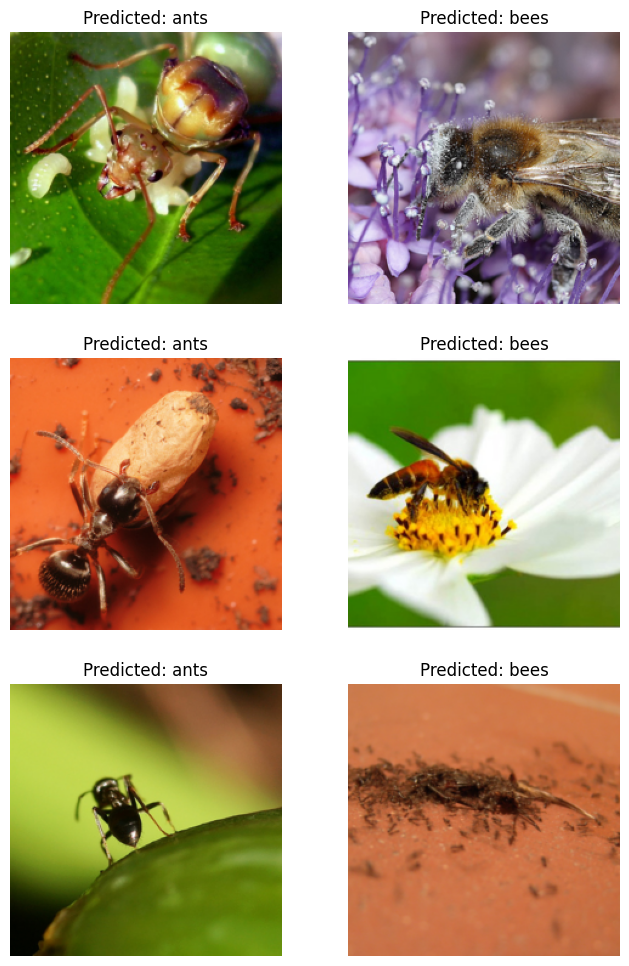

In [26]:
visualize_model(model, data_loaders['val'])

# **Custom Prediction with Images from web**

In [27]:
class WebDataSet(torch.utils.data.Dataset):
  def __init__(self, remote_addrs, transform):
    self.remote_addrs = remote_addrs
    self.transform = transform

  def __len__(self):
    return len(self.remote_addrs)

  def __getitem__(self, idx):
    image = self.load_remote_image(self.remote_addrs[idx], self.transform)
    return image, torch.Tensor([0])

  def load_remote_image(self, remote_addr, transform):
    response = requests.get(remote_addr)
    image = Image.open(BytesIO(response.content))
    tr_image = transform(image)
    return tr_image

In [28]:
bees_images = ['https://westernpest.com/wp-content/uploads/honey-bee-4.jpg', 'https://www.westernpest.com/wp-content/uploads/bumble-bee-2.jpg', 'https://www.westernpest.com/wp-content/uploads/bumble-bee-5.jpg']
ants_images = ['https://cdn.britannica.com/42/223142-050-7033F421/Red-ant-on-a-green-branch.jpg', 'https://cdn.britannica.com/55/88055-050-95880081/Black-carpenter-ant.jpg']

web_urls = bees_images + ants_images

custom_dd_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=_mean, std=_std)
])
custom_dd = WebDataSet(web_urls, custom_dd_transform)

custom_dd_loader = DataLoader(custom_dd, batch_size=2, shuffle=True)

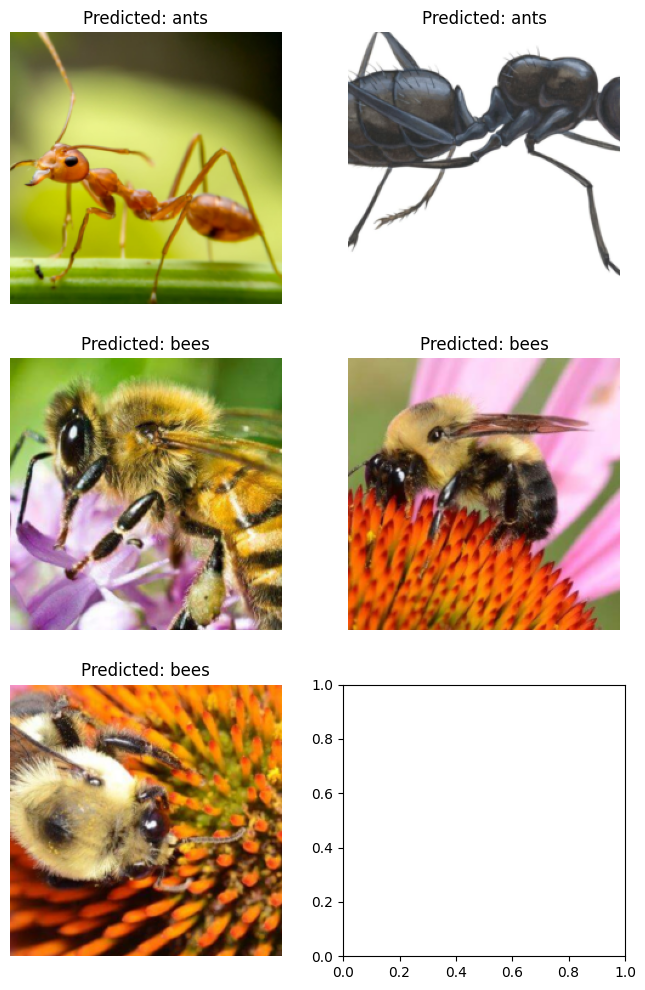

In [29]:
visualize_model(model, custom_dd_loader)

In [ ]:
t1 = torch.Tensor([1],[2])
t2 = torch.Tensor([2],[3])
torch.sum(t1 == t2).item()

TypeError: new() received an invalid combination of arguments - got (list, list), but expected one of:
 * (*, torch.device device = None)
      didn't match because some of the arguments have invalid types: (!list of [int]!, !list of [int]!)
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device = None)
 * (object data, *, torch.device device = None)
